In [1]:
%matplotlib notebook
import os
import sys
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis, skeletonize
from skan import skeleton_to_csgraph, _testdata, draw, Skeleton, summarize

sys.path.insert(0, os.path.abspath('../'))
from src.lib import centroids as centutils

plt.rcParams['figure.figsize'] = [10, 10]

/home/juanjo/VirtualEnvs/Fondef/lib/python3.8/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


<IPython.core.display.Javascript object>


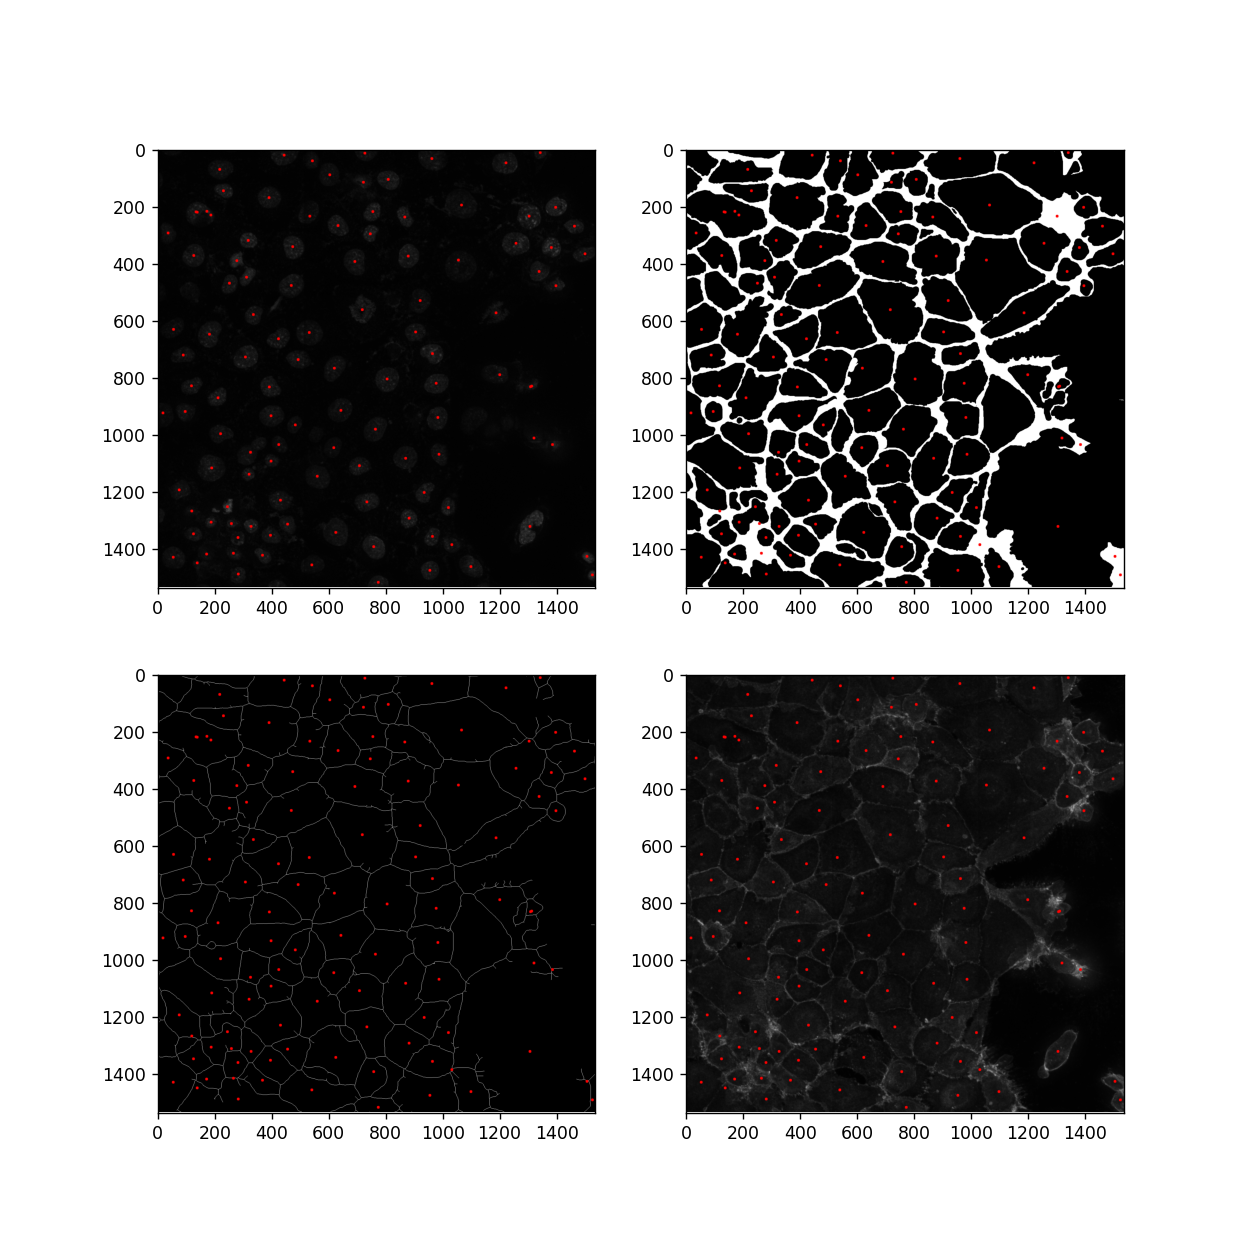

In [2]:
nuclei_path = '../data/first/Nuclei/AKT1_B1_CAn.tif'
jbin_path = '../data/first/Segmented/AKT1_B1_CAj-BI.tif'
jsk_path = '../data/first/Skeletonized/AKT1_B1_CAj-SK.tif'
j_path = '../data/first/Original/AKT1_B1_CAj.tif'

nuclei_img = cv2.imread(nuclei_path)
jbin_img = cv2.imread(jbin_path)
jsk_img = cv2.imread(jsk_path)
j_img = cv2.imread(j_path)

centroids = centutils.get_nuclei_centroids(nuclei_img)

nuclei_centroids = nuclei_img.copy()
jbin_centroids = jbin_img.copy()
jsk_centroids = jsk_img.copy()
j_centroids = j_img.copy()


for x, y in centroids:
    cv2.circle(nuclei_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jbin_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(jsk_centroids, (x, y), 5, (255, 0, 0), -1)
    cv2.circle(j_centroids, (x, y), 5, (255, 0, 0), -1)

    
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(nuclei_centroids)
ax[0,1].imshow(jbin_centroids)
ax[1,0].imshow(jsk_centroids)
ax[1,1].imshow(j_centroids)

# Medial Axis

In [35]:
jbin_path = '../data/Test/Segmented/NF2_D1_NSj-BI.tif'
jbin_img = cv2.imread(jbin_path)
jbin_img_gray = cv2.cvtColor(jbin_img, cv2.COLOR_BGR2GRAY)


skel, distance = medial_axis(jbin_img_gray, return_distance=True)
dist_on_skel = distance * skel

<IPython.core.display.Javascript object>


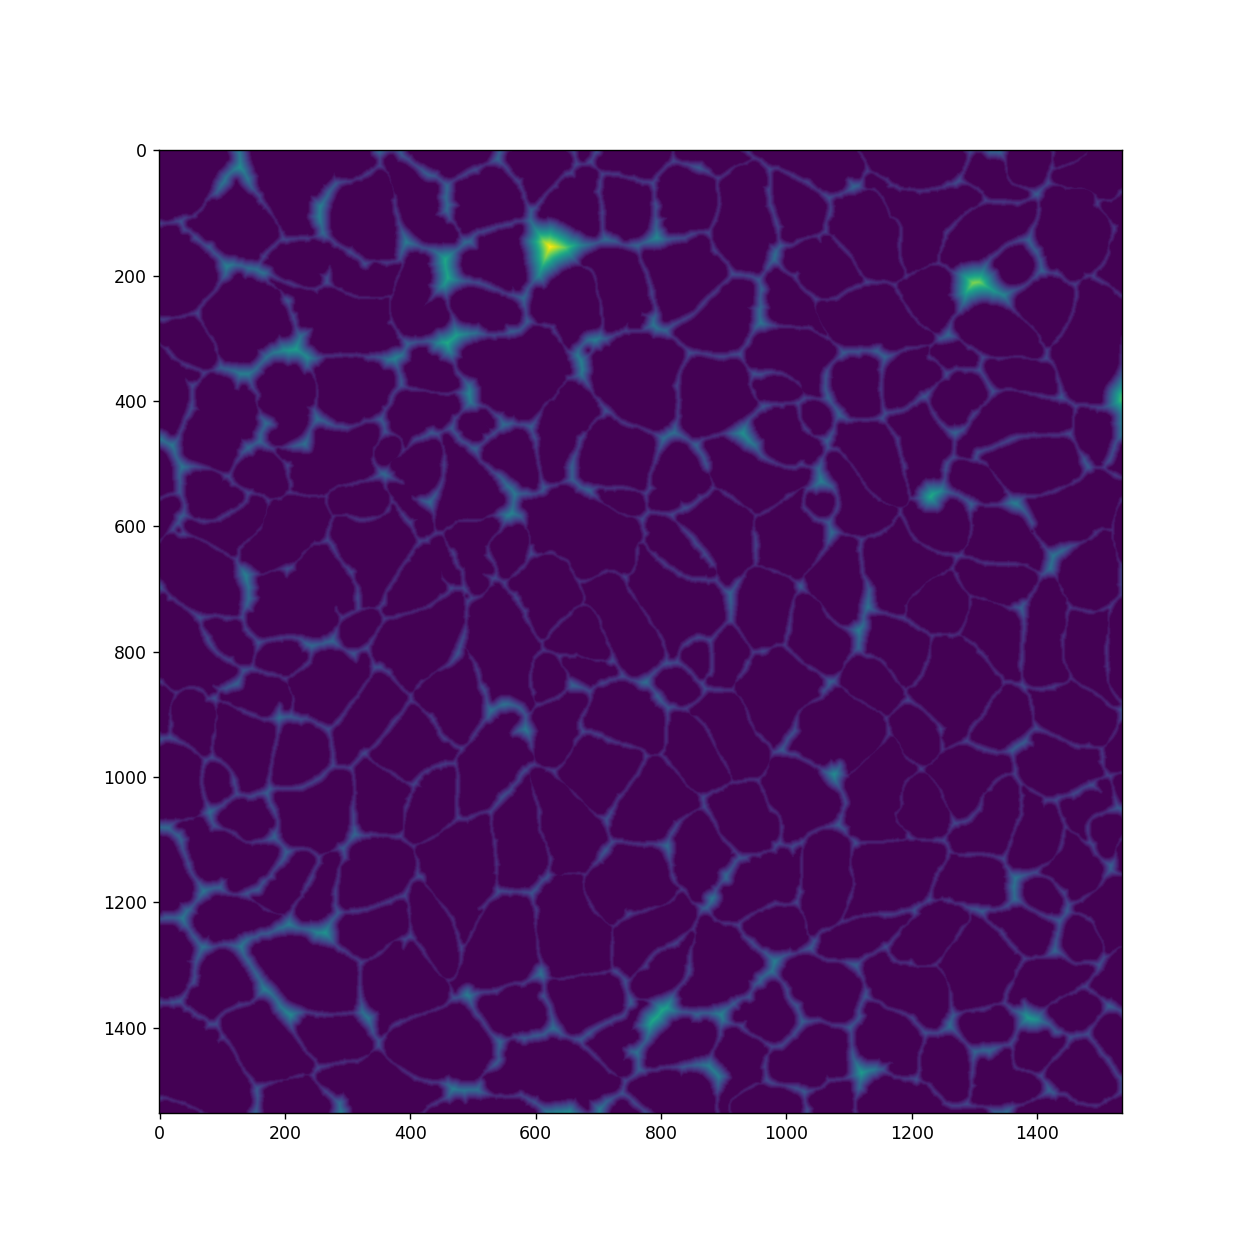

In [36]:
plt.imshow(distance)

<IPython.core.display.Javascript object>


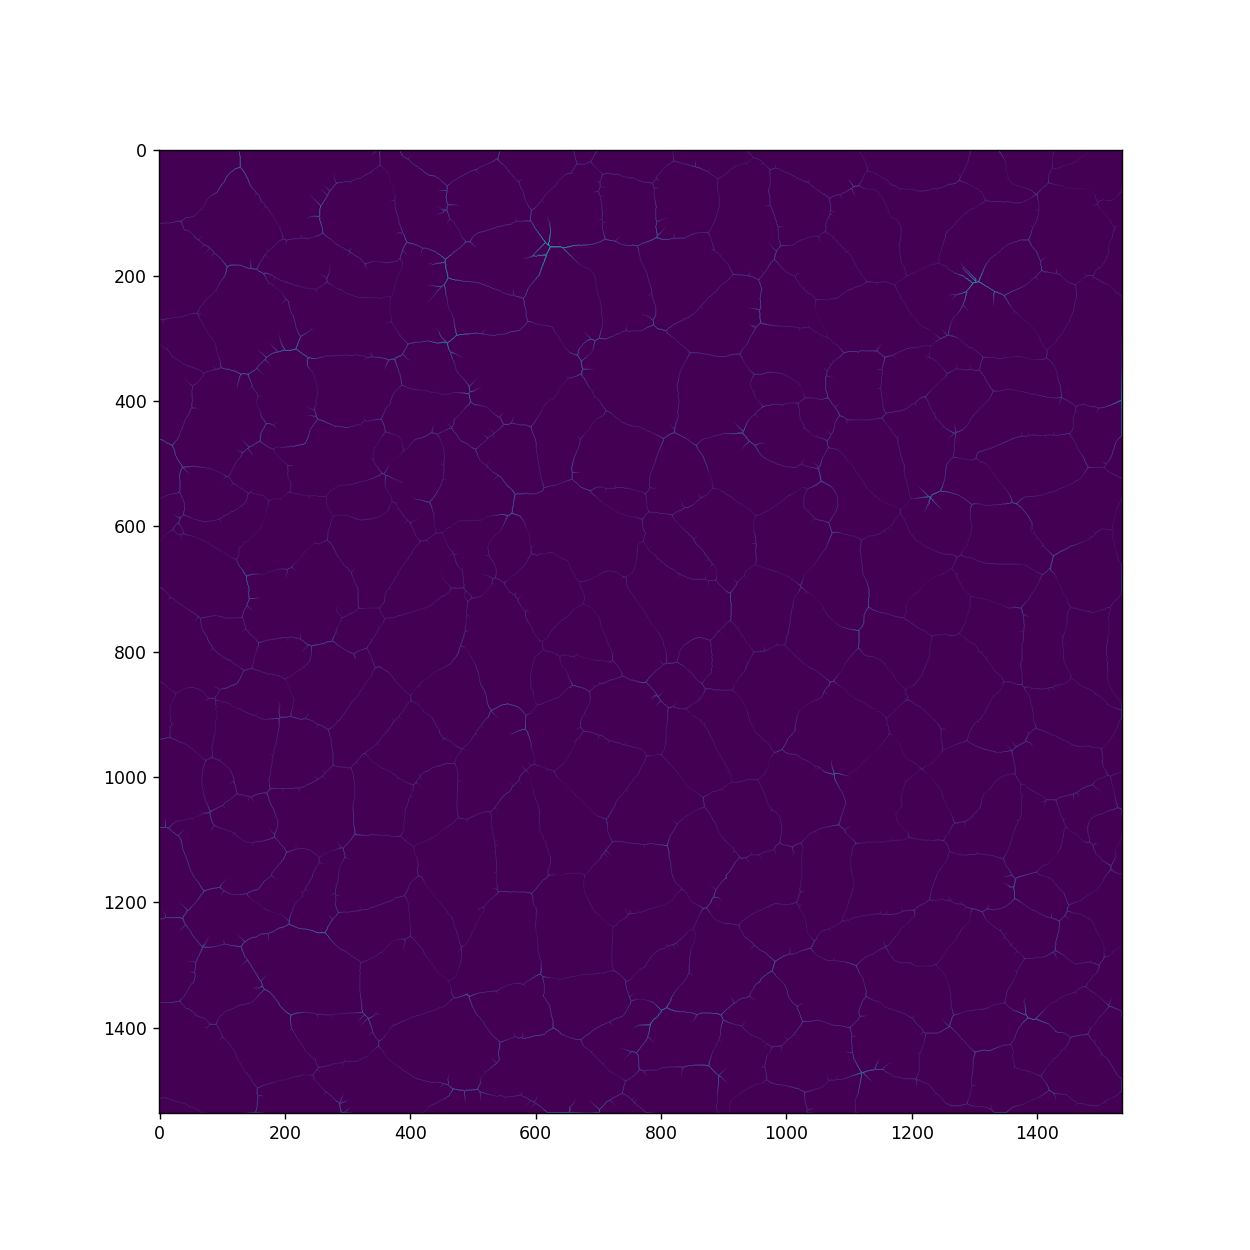

In [37]:
plt.imshow(dist_on_skel)

In [38]:
flat = dist_on_skel.flatten()
flat = flat[np.where(flat != 0)]
mean, std  = flat.mean(), flat.std()
mean, std

(7.3150807473272925, 4.571569081996812)

In [39]:
dist_on_skel.std(), dist_on_skel.mean()

(1.215617366342642, 0.14740875412418855)

In [40]:
dist_on_skel[np.where(dist_on_skel != 0)].mean()

7.3150807473272925

In [41]:
def medial_axis_stadistics(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    skel, distance = medial_axis(img_gray, return_distance=True)
    dist_on_skel = distance * skel
    non_zero = dist_on_skel[np.where(dist_on_skel != 0)]
    return non_zero.mean(), non_zero.std()

In [42]:
print(medial_axis_stadistics(jbin_img))

(7.3150807473272925, 4.571569081996812)


# Generalized Voronoi

<IPython.core.display.Javascript object>


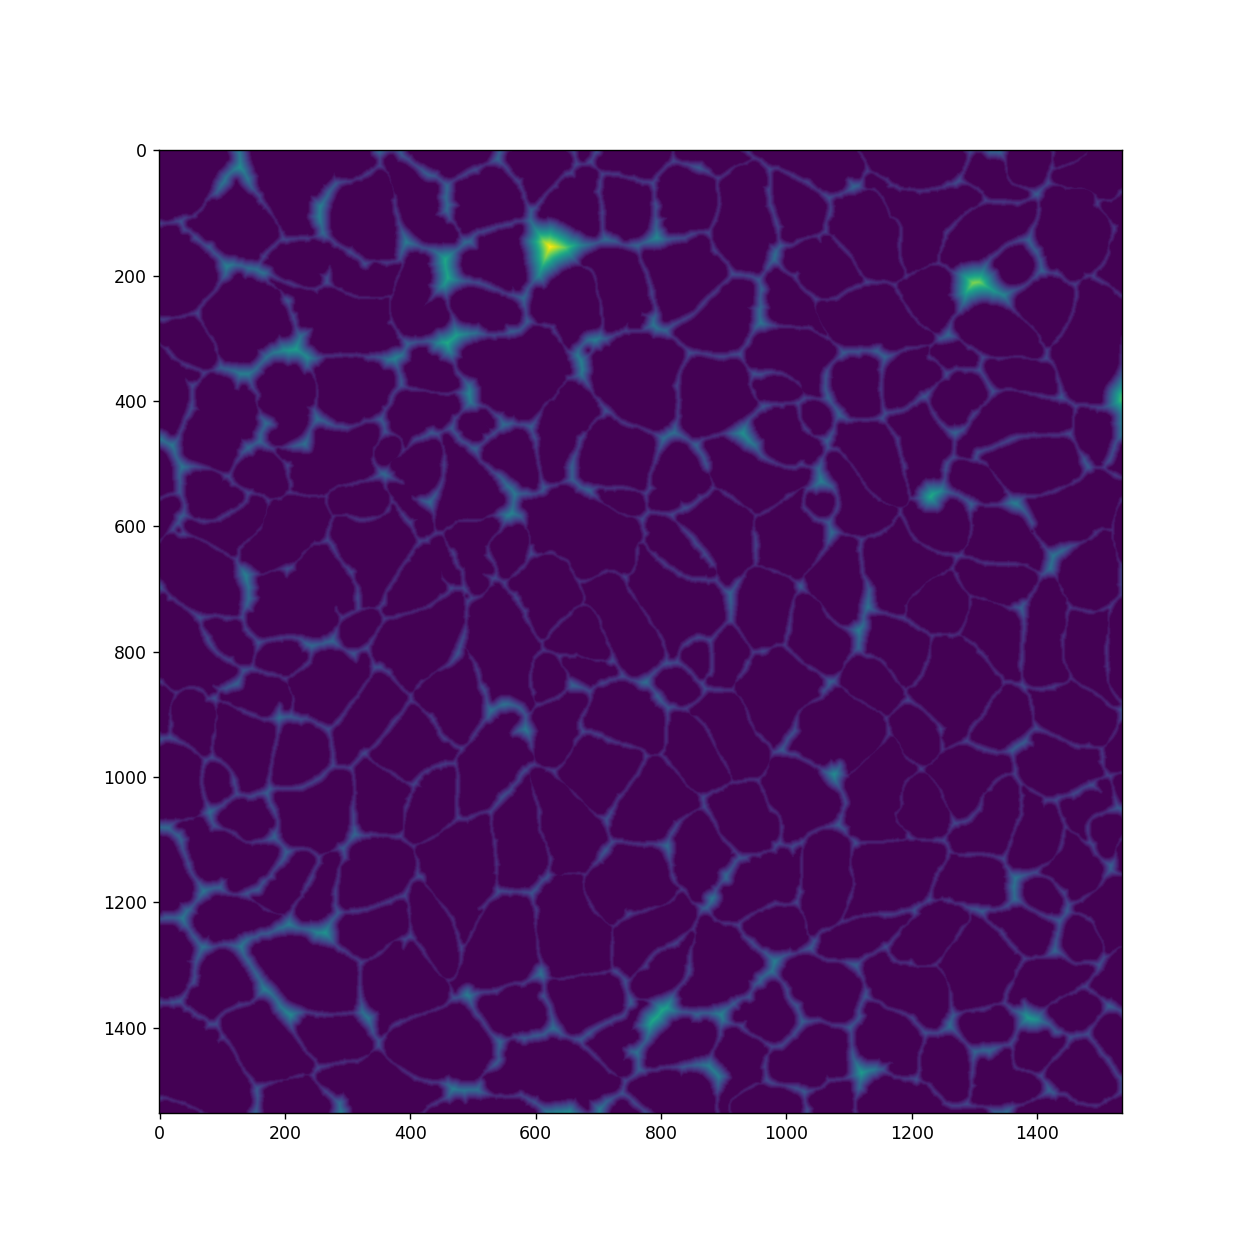

In [43]:
jbin_img = cv2.imread(jbin_path)
img_gray = cv2.cvtColor(jbin_img, cv2.COLOR_BGR2GRAY)

distance = ndi.distance_transform_edt(img_gray)
plt.imshow(distance)

### A little detour

In Matlab, the function bwdist calculates the Euclidean Distance Transform (EDT) as ilustrated in the next example from MATLAB official documentation:
![title](img/bwdist.png)

Nevertheless, what happens if we try to compute the same result in Python?

In [44]:
bw_test = np.zeros((5,5), dtype=bool)
bw_test[1,1] = 1 # Indexing in Python is 0-based, while in Matlab is 1-based
bw_test[3,3] = 1
bw_test.astype(int)

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

In [45]:
distance_test = ndi.distance_transform_edt(bw_test)
distance_test

array([[0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.]])

It gives a different result! This happens because in Matlab the EDT (bwdist function) computes the distance from each pixel to its nearest nonzero neighbour, while in Python the EDT (ndi.distance_transform_edt function) calculates the distance from each pixel to its closest background neighbour (i.e., to the nearest 0 pixel). So, if we want the same result in Python we should invert the image/matrix, as in the next example:

In [46]:
bw_test_inv = ~bw_test
distance_test_inv = ndi.distance_transform_edt(bw_test_inv)
distance_test_inv

array([[1.41421356, 1.        , 1.41421356, 2.23606798, 3.16227766],
       [1.        , 0.        , 1.        , 2.        , 2.23606798],
       [1.41421356, 1.        , 1.41421356, 1.        , 1.41421356],
       [2.23606798, 2.        , 1.        , 0.        , 1.        ],
       [3.16227766, 2.23606798, 1.41421356, 1.        , 1.41421356]])

And now we have the same result. Although now it seems obvious, it took me a lot of time last night to realize that difference :(

### Resuming...

<IPython.core.display.Javascript object>


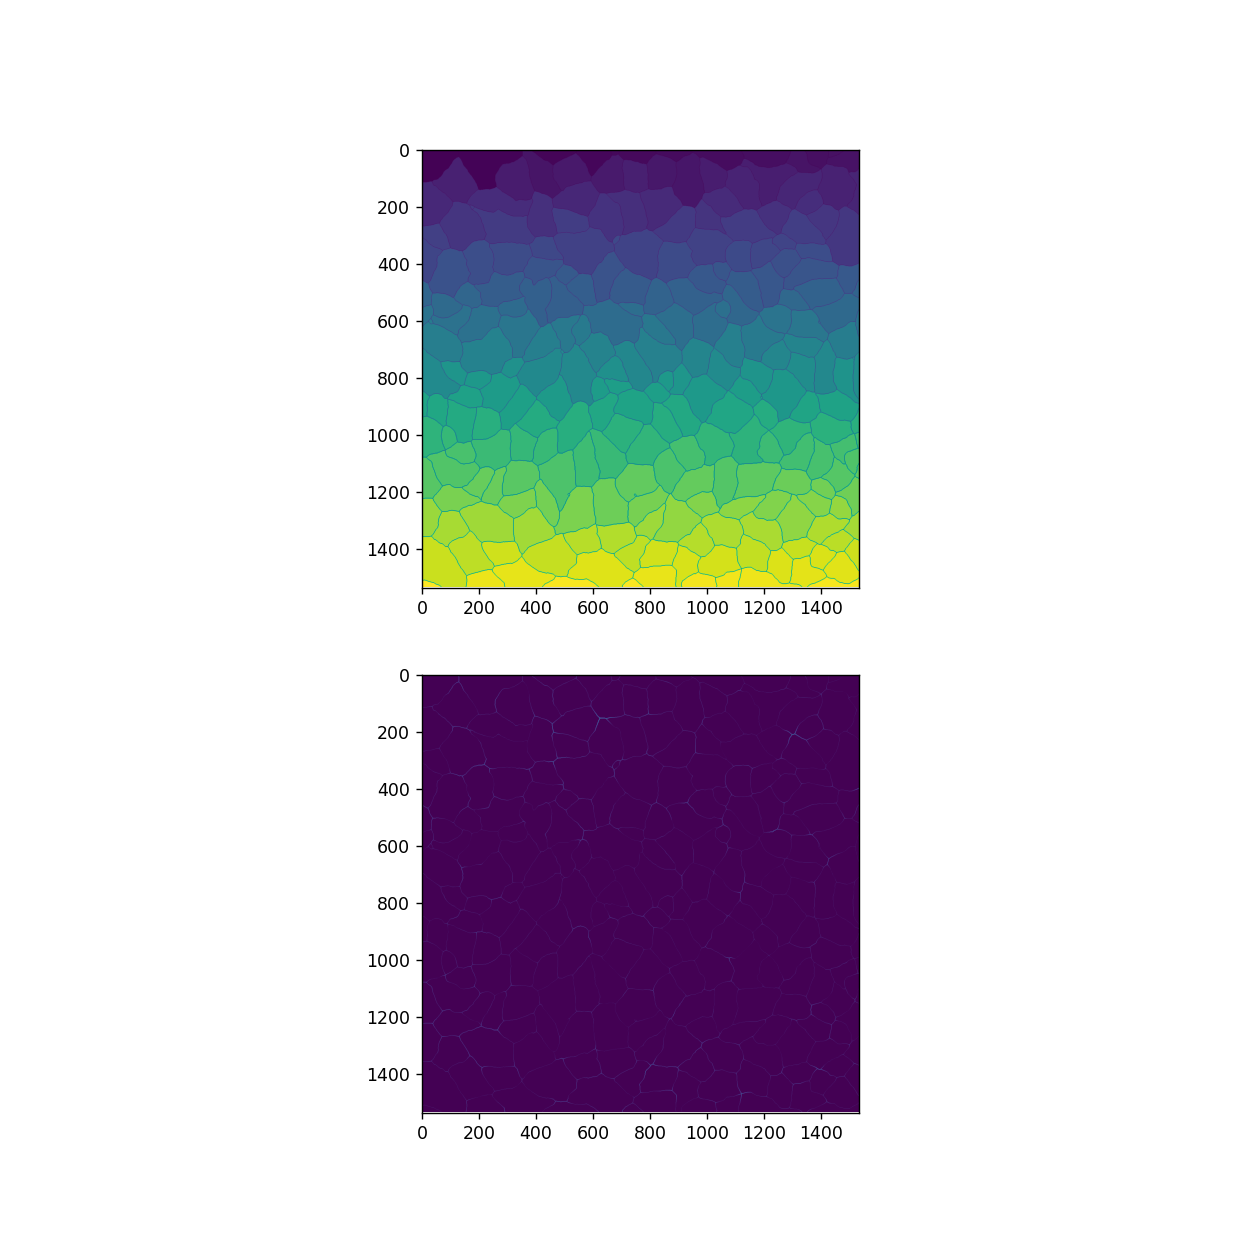

In [47]:
local_maxi = peak_local_max(-distance, indices=False, footprint=np.ones((3, 3)),
                            labels=img_gray)
markers = ndi.label(local_maxi)[0]
labels = watershed(distance, markers, watershed_line=True)
mask = labels == 0
distance_skel = distance.copy()
distance_skel[~mask] = 0
fig, axes = plt.subplots(2)
axes[0].imshow(labels)
axes[1].imshow(distance_skel)

In [75]:
x1 = np.where(distance_skel != 0)
x2 = np.where(mask)

In [84]:
s1 = set(zip(*x1))
s2 = set(zip(*x2))

s2 - s1, s1 - s2, distance_skel[0, 1480], labels[0, 1480], distance[0, 1480]

({(0, 1480)}, set(), 0.0, 0, 0.0)

<IPython.core.display.Javascript object>


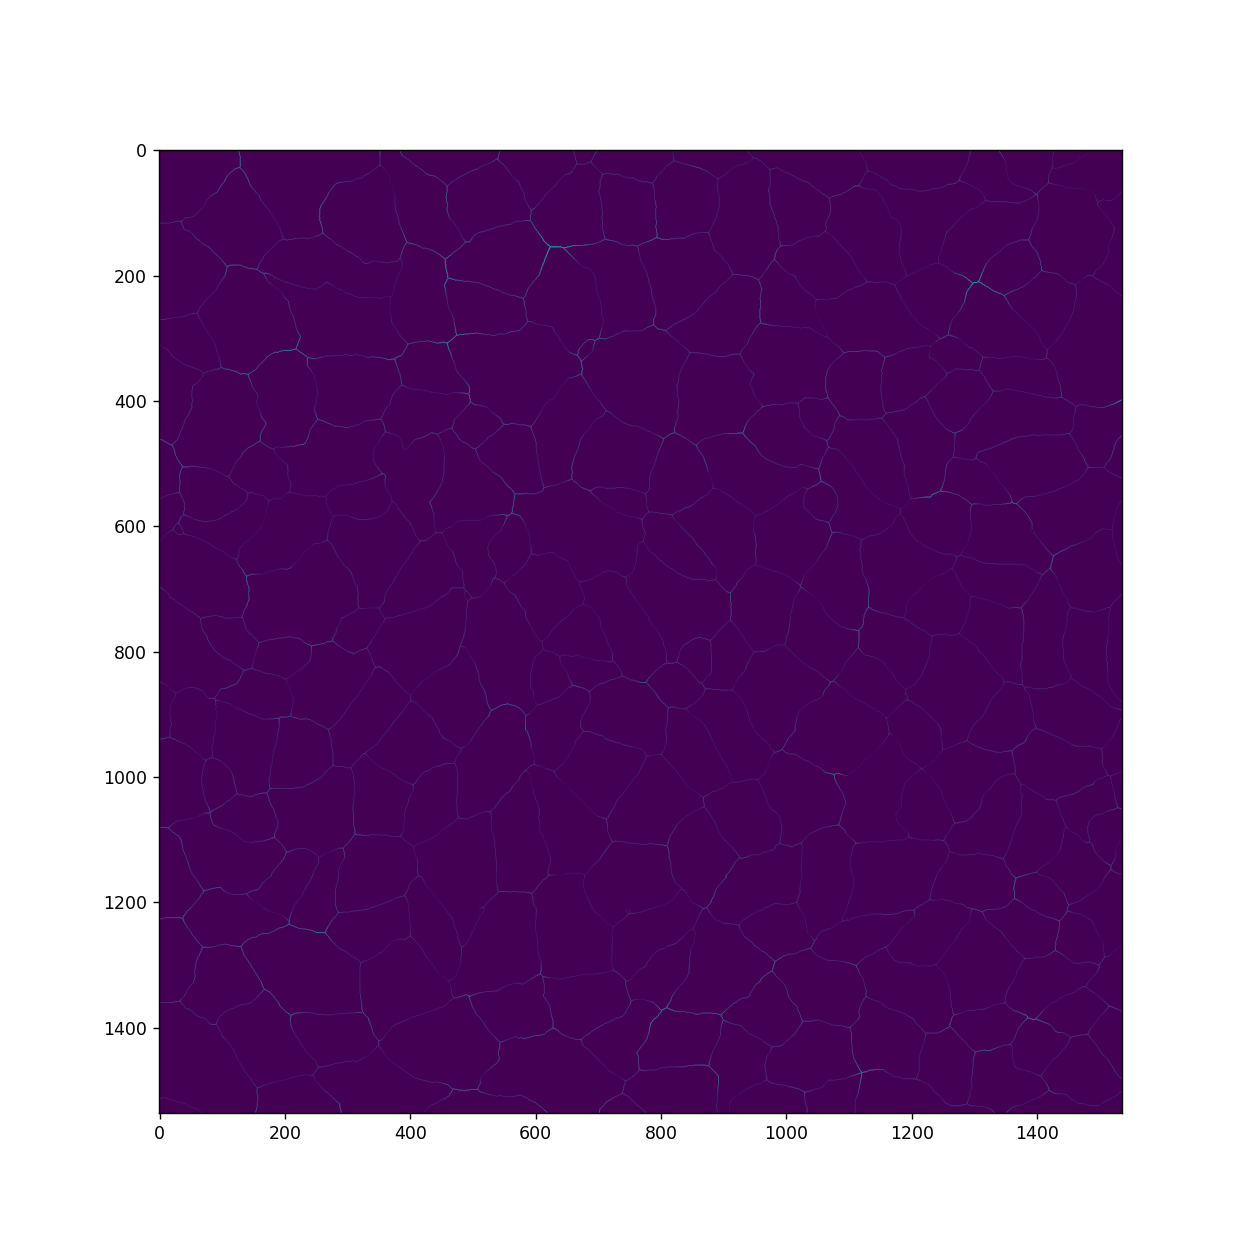

In [81]:
plt.imshow(distance_skel)

In [14]:
def voronoi_approx_statistics(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    distance = ndi.distance_transform_edt(img_gray)
    local_maxi = peak_local_max(-distance, indices=False, footprint=np.ones((3, 3)), labels=img_gray)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(distance, markers, watershed_line=True)
    mask = labels == 0
    distance_skel = distance.copy()
    distance_skel[~mask] = 0
    non_zero = distance_skel[mask]
    return non_zero.mean(), non_zero.std()

In [15]:
voronoi_approx_statistics(jbin_img)

(7.98889305061714, 5.427055974832857)